# MNIST Handwritten Digits Classification
*   A comprehensive CNN implementation for digit recognition using PyTorch.
*   Achieves high accuracy through modern deep learning techniques
including data augmentation, batch normalization, dropout regularization, and early stopping



# Data Pre-Processing

## Imports


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import os

In [19]:
# Set device to GPU if available, otherwise CPU
# This allows for faster training on systems with CUDA-compatible GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Seed Assignment

In [20]:
def set_all_seeds(seed):
    """
    Set all random seeds for reproducibility and potentially better performance
    Different seeds can lead to different model performance due to:
    - Different weight initialization
    - Different data shuffling patterns
    - Different dropout patterns during training
    - Different augmentation variations
    """
    print(f"Setting all random seeds to: {seed}")
    
    # Set Python's built-in random seed
    random.seed(seed)
    
    # Set NumPy random seed (affects data shuffling, train/test splits)
    np.random.seed(seed)
    
    # Set PyTorch random seeds (affects weight initialization, dropout)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Set environment variable for Python hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Make CuDNN operations deterministic (may slightly reduce performance but ensures reproducibility)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# SET YOUR CHOSEN SEED HERE - Try different values to potentially improve accuracy
# Good seeds to try: 42, 123, 777, 1337, 2024, 9999, 555, 888, 2023, 2025
SEED = 777  # Change this value manually to experiment with different seeds
set_all_seeds(SEED)

Setting all random seeds to: 777


## Loading the MNIST Dataset (Specifically from Kaggle)






In [21]:
# Custom dataset class to handle CSV format data instead of built-in MNIST

class KaggleDatasetLoader(Dataset):
    """
    Custom Dataset class for Kaggle Digit Recognizer CSV data
    Handles both training data (with labels) and test data (without labels)
    """
    def __init__(self, dataframe, transform=None, has_labels=True):
        self.dataframe = dataframe
        self.transform = transform
        self.has_labels = has_labels
        
        if has_labels and 'label' in dataframe.columns:
            self.labels = dataframe['label'].values  # Extract labels column
            self.images = dataframe.drop(columns=['label']).values  # Remove labels from image data
        else:
            self.labels = None
            self.images = dataframe.values  # All columns are pixel values
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Reshape flat 784 pixel values back to 28x28 image
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        image = Image.fromarray(image, mode='L')  # Convert to PIL Image for transforms
        
        if self.transform:
            image = self.transform(image)  # Apply transformations
        
        if self.has_labels and self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image  # Return only image for test data (no labels)

# Load Kaggle competition CSV files
# train.csv contains 42,000 samples with pixel values and labels
# test.csv contains 28,000 samples with only pixel values (no labels)
train_csv = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')  # Load training data with labels
test_csv = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')    # Load test data without labels

# Data augmentation for training - improves generalization by creating variations of training data
transform_train = transforms.Compose([
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees to simulate natural handwriting variations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translate by ±10% to handle position variations
    transforms.ToTensor(),  # Convert PIL image to tensor and scale pixels from [0,255] to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Standardize using MNIST's mean=0.1307, std=0.3081
])

# Test transformation without augmentation - ensures consistent evaluation conditions
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and normalize to [0,1] range
    transforms.Normalize((0.1307,), (0.3081,))  # Apply same normalization as training for consistency
])

# Create dataset instances
full_train_dataset = KaggleDatasetLoader(train_csv, transform=transform_train, has_labels=True)  # Training data with labels
kaggle_test_dataset = KaggleDatasetLoader(test_csv, transform=transform_test, has_labels=False)  # Test data without labels

# Split Kaggle training data into train and validation sets
# Use stratified split to maintain class distribution across splits
train_indices, valid_indices = train_test_split(
    np.arange(len(full_train_dataset)), 
    test_size=0.2,  # 20% for validation
    random_state=42,  # For reproducible splits
    stratify=train_csv['label']  # Maintain class balance in both splits
)

# Create train and validation subsets
train_data = Subset(full_train_dataset, train_indices)  # ~33,600 samples for training
valid_data = Subset(full_train_dataset, valid_indices)  # ~8,400 samples for validation

# Note: For Kaggle submission, you'll use kaggle_test_dataset for final predictions
test_data = kaggle_test_dataset  # 28,000 samples for Kaggle submission

## Visualizing the Dataset

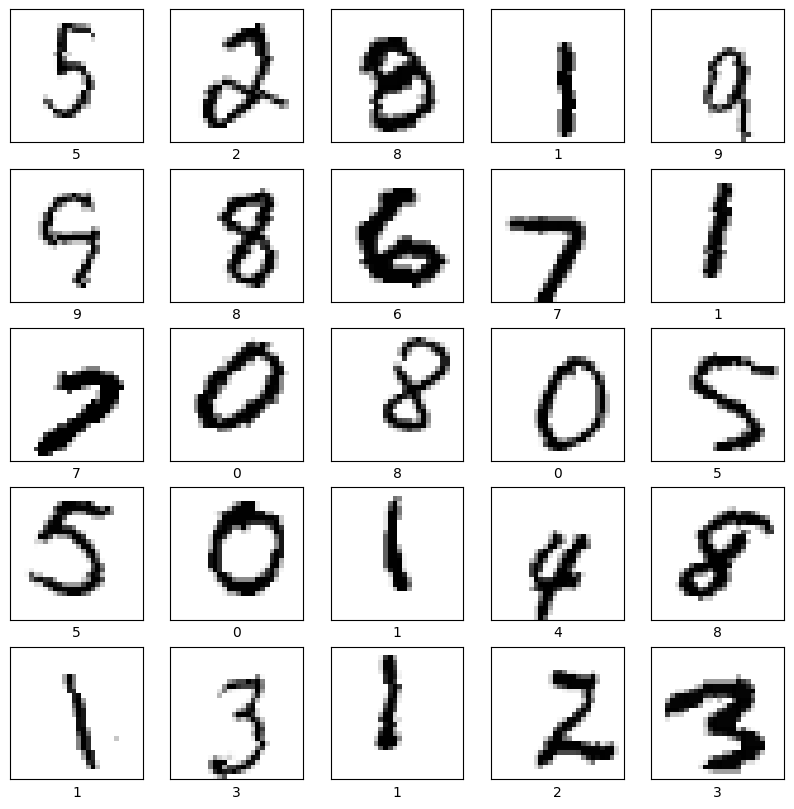

In [22]:
plt.figure(figsize=(10,10))  # Create large figure for clear visualization of 25 samples
train_length = len(train_data)  # Get total number of training samples (60,000)
indices = list(range(train_length))  # Create list of all possible indices
np.random.shuffle(indices)  # Randomize indices to get diverse sample representation

for i in range(25):  # Display 25 random samples in 5x5 grid
    plt.subplot(5, 5, i + 1)  # Create subplot in 5x5 grid layout
    plt.xticks([])  # Remove x-axis ticks for cleaner appearance
    plt.yticks([])  # Remove y-axis ticks for cleaner appearance
    image_index = indices[i]  # Get random image index
    image, label = train_data[image_index]  # Extract image tensor and corresponding label
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)  # Display grayscale image (squeeze removes channel dimension)
    plt.xlabel(label)  # Show true digit label below each image

## DataLoader setup

In [23]:
batch_size = 64  # Process 64 samples per batch - balance between memory usage and gradient stability
valid_size=0.2  # Reserve 20% of training data for validation to monitor overfitting
num_workers=0  # Single-threaded data loading (safer for debugging, can increase for speed)

split = int(np.floor(valid_size * train_length))  # Calculate number of validation samples (12,000)
train_idx, valid_idx = indices[split:], indices[:split]  # Split indices: 48,000 train, 12,000 validation
train_sampler = SubsetRandomSampler(train_idx)  # Random sampler for training subset
valid_sampler = SubsetRandomSampler(valid_idx)  # Random sampler for validation subset

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)  # Training data loader with random sampling
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)  # Validation data loader with random sampling
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False,
    num_workers=num_workers)  # Test data loader (no sampler needed - uses all test data)

In [24]:
len(train_loader),len(valid_loader),len(test_loader)  # Display number of batches in each loader

(420, 105, 438)

# Model Architecture

## Defining the model
Standard formulas used to calculate output shapes: (for convolution & pooling layers)
```
Output = floor((Input + 2×Padding - Kernel) / Stride) + 1

```



In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            # First block - Extract basic features like edges and simple patterns
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x28x28 → Output: 32x28x28 (32 feature maps)
            nn.BatchNorm2d(32),  # Normalize activations to speed up training and reduce internal covariate shift
            nn.ReLU(inplace=True),  # Non-linear activation function, inplace=True saves memory
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Output: 32x28x28 (deeper feature extraction)
            nn.BatchNorm2d(32),  # Batch normalization for stable training
            nn.ReLU(inplace=True),  # ReLU activation for non-linearity
            nn.MaxPool2d(kernel_size=2),  # Output: 32x14x14 (reduce spatial dimensions by half)
            nn.Dropout2d(0.25),  # Randomly zero 25% of feature maps to prevent overfitting

            # Second block - Extract more complex features and patterns
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: 64x14x14 (increase feature depth)
            nn.BatchNorm2d(64),  # Normalize 64 feature channels
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: 64x14x14 (deeper feature learning)
            nn.BatchNorm2d(64),  # Batch normalization for training stability
            nn.ReLU(inplace=True),  # ReLU activation
            nn.MaxPool2d(kernel_size=2),  # Output: 64x7x7 (further spatial reduction)
            nn.Dropout2d(0.25),  # 25% dropout for regularization

            # Third block - Extract high-level abstract features
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x7x7 (highest feature complexity)
            nn.BatchNorm2d(128),  # Normalize 128 feature channels
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.Dropout2d(0.25)  # Dropout for regularization before classification
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling: 128x7x7 → 128x1x1 (robust to input size)
            nn.Flatten(),  # Convert 2D feature maps to 1D vector: 128x1x1 → 128
            nn.Linear(128, 512),  # Fully connected layer for feature combination and decision making
            nn.BatchNorm1d(512),  # Batch normalization for fully connected layer
            nn.ReLU(inplace=True),  # Non-linear activation
            nn.Dropout(0.5),  # Higher dropout (50%) for fully connected layers to prevent overfitting
            nn.Linear(512, 10)  # Output layer: 512 → 10 classes (digits 0-9)
        )

    def forward(self, x):
        x = self.features(x)  # Pass through convolutional feature extraction layers
        x = self.classifier(x)  # Pass through classification layers
        return x  # Return logits for 10 digit classes

## Training and Validation Phase

In [26]:
def trainCNN(model):
    loss_data={'train':[],'valid':[]}  # Store losses for each epoch to plot training curves
    optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with 0.001 learning rate (adaptive, works well for most cases)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)  # Reduce LR by 50% every 15 epochs for fine-tuning
    epochs = 30  # Maximum number of training epochs
    loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)  # Cross-entropy with label smoothing to prevent overconfident predictions
    patience = 5  # Early stopping: wait 5 epochs without improvement
    patience_counter = 0  # Counter for epochs without validation improvement

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.inf  # Track best validation loss for model saving

    for epoch in range(epochs):
        train_loss=0.0  # Accumulate training loss for this epoch
        valid_loss=0.0  # Accumulate validation loss for this epoch
        epoch_start = time.time()  # Record start time for epoch duration calculation

       # TRAINING PHASE
        model.train()  # Set model to training mode (enables dropout and batch norm training)
        for images,labels in train_loader:  # Iterate through training batches
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()  # Clear gradients from previous iteration
            output=model(images)  # Forward pass: get model predictions
            loss=loss_function(output,labels)  # Calculate loss between predictions and true labels
            loss.backward()  # Backward pass: compute gradients
            optimizer.step()  # Update model parameters using gradients
            train_loss+=loss.item()  # Accumulate batch loss

       # VALIDATION PHASE
        model.eval()  # Set model to evaluation mode (disables dropout, uses running batch norm stats)
        with torch.no_grad():  # Disable gradient computation for efficiency and memory
            for images,labels in valid_loader:  # Iterate through validation batches
                images, labels = images.to(device), labels.to(device)  # Move data to GPU
                output=model(images)  # Forward pass only (no gradient computation)
                loss=loss_function(output,labels)  # Calculate validation loss
                valid_loss+=loss.item()  # Accumulate validation loss

        train_loss = train_loss/len(train_loader)  # Calculate average training loss per batch
        valid_loss = valid_loss/len(valid_loader)  # Calculate average validation loss per batch
        loss_data['train'].append(train_loss)  # Store training loss for plotting
        loss_data['valid'].append(valid_loss)  # Store validation loss for plotting

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss <= valid_loss_min:  # Check if validation loss improved
            print(f"Validation loss decreased from : {valid_loss_min:.4f} ----> {valid_loss:.4f} ----> Saving Model.......")
            z = type(model).__name__  # Get model class name for file naming
            torch.save(model.state_dict(), z+'_model.pth')  # Save best model weights
            valid_loss_min = valid_loss  # Update best validation loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter if no improvement
            if patience_counter >= patience:  # Check if patience exceeded
                print(f"Early stopping triggered after {patience} epochs without improvement")
                break  # Stop training to prevent overfitting
        epoch_time = time.time() - epoch_start  # Calculate epoch duration
        print(f"Epoch completed in {epoch_time:.2f} seconds")

        scheduler.step()  # Update learning rate according to schedule

    return(loss_data)  # Return loss history for plotting

In [27]:
cnn_model=CNN()  # Initialize CNN model instance
cnn_model.to(device)  # Move model to GPU if available
cnn_loss=trainCNN(cnn_model)  # Train the model and get loss history


Epoch : 1	Training Loss : 1.2538522459211803	Validation Loss : 0.6720340961501712
Validation loss decreased from : inf ----> 0.6720 ----> Saving Model.......
Epoch completed in 15.64 seconds

Epoch : 2	Training Loss : 0.7474626761107218	Validation Loss : 0.6131894054866972
Validation loss decreased from : 0.6720 ----> 0.6132 ----> Saving Model.......
Epoch completed in 15.63 seconds

Epoch : 3	Training Loss : 0.6776132509821937	Validation Loss : 0.5819573697589693
Validation loss decreased from : 0.6132 ----> 0.5820 ----> Saving Model.......
Epoch completed in 15.49 seconds

Epoch : 4	Training Loss : 0.641546952582541	Validation Loss : 0.573482418627966
Validation loss decreased from : 0.5820 ----> 0.5735 ----> Saving Model.......
Epoch completed in 15.60 seconds

Epoch : 5	Training Loss : 0.6239655574162801	Validation Loss : 0.5637819114185515
Validation loss decreased from : 0.5735 ----> 0.5638 ----> Saving Model.......
Epoch completed in 15.60 seconds

Epoch : 6	Training Loss : 0.6

### Loading model from Lowest Validation Loss

In [28]:
cnn_model.load_state_dict(torch.load('CNN_model.pth', map_location=device))  # Load best model weights, map_location ensures device compatibility
print(cnn_model.state_dict)  # Print confirmation of loaded model parameters

<bound method Module.state_dict of CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, st


### Plotting Training and Validation Losses

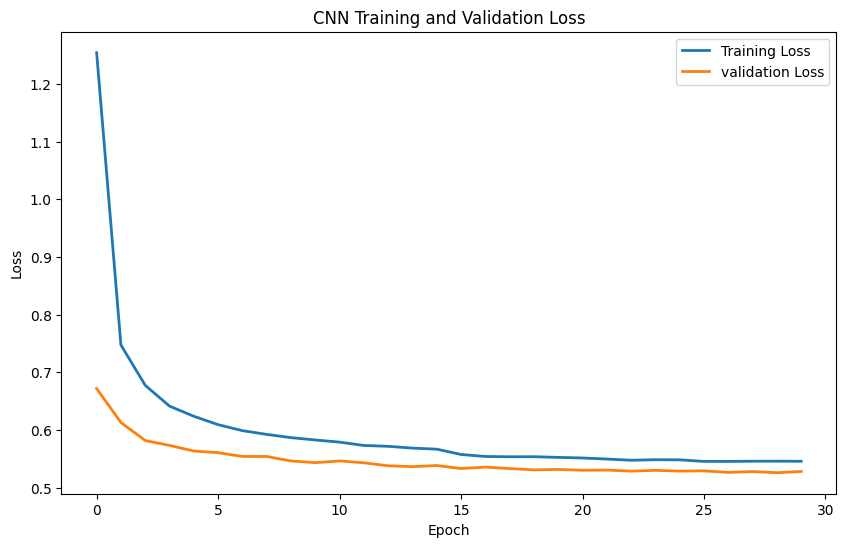

In [29]:
plt.figure(figsize=(10, 6))  # Create figure for loss visualization
plt.plot(cnn_loss['train'], label='Training Loss',linewidth=2)  # Plot training loss curve
plt.plot(cnn_loss['valid'], label='validation Loss', linewidth=2)  # Plot validation loss curve
plt.title('CNN Training and Validation Loss')  # Add descriptive title
plt.xlabel('Epoch')  # Label x-axis
plt.ylabel('Loss')  # Label y-axis
plt.legend()  # Show legend to distinguish curves
plt.show()  # Display the plot

## Testing Phase

In [30]:
def testCNN(model):
    """
    Generate predictions for test set and creates a submission file in csv format to submit the predictions
    """
    model.eval()  # Set model to evaluation mode
    predictions = []  # Store all predictions
    
    print("Generating predictions for Kaggle submission...")
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_idx, images in enumerate(test_loader):  # Iterate through test data (no labels)
            images = images.to(device)  # Move images to GPU
            outputs = model(images)  # Get model predictions (logits)
            _, preds = torch.max(outputs, 1)  # Get predicted class (highest probability)
            predictions.extend(preds.cpu().numpy())  # Convert to numpy and add to list
            
            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"Processed {(batch_idx + 1) * test_loader.batch_size} images...")
    
    # Create submission DataFrame with required Kaggle format
    submission_df = pd.DataFrame({
        'ImageId': list(range(1, len(predictions) + 1)),  # ImageId starts from 1
        'Label': predictions  # Predicted digit labels
    })
    
    # Save to CSV file for Kaggle submission
    filename = 'digit_recognizer_submission.csv'
    submission_df.to_csv(filename, index=False)  # index=False prevents adding row numbers
    print(f'Submission file "{filename}" created successfully!')
    print(f'Total predictions: {len(predictions)}')
    print(f'First 10 predictions: {predictions[:10]}')
    
    # Display prediction distribution for verification
    unique, counts = np.unique(predictions, return_counts=True)
    print("\nPrediction distribution:")
    for digit, count in zip(unique, counts):
        print(f"Digit {digit}: {count} predictions ({count/len(predictions)*100:.1f}%)")
    
    return submission_df

In [31]:
# Generate Kaggle submission file
submission_df = testCNN(cnn_model)  # Run submission generation

# Display first few rows of submission file
print("\nFirst 10 rows of submission file:")
print(submission_df.head(10))

Generating predictions for Kaggle submission...
Processed 3200 images...
Processed 6400 images...
Processed 9600 images...
Processed 12800 images...
Processed 16000 images...
Processed 19200 images...
Processed 22400 images...
Processed 25600 images...
Submission file "digit_recognizer_submission.csv" created successfully!
Total predictions: 28000
First 10 predictions: [2, 0, 9, 0, 3, 7, 0, 3, 0, 3]

Prediction distribution:
Digit 0: 2771 predictions (9.9%)
Digit 1: 3199 predictions (11.4%)
Digit 2: 2806 predictions (10.0%)
Digit 3: 2787 predictions (10.0%)
Digit 4: 2751 predictions (9.8%)
Digit 5: 2502 predictions (8.9%)
Digit 6: 2748 predictions (9.8%)
Digit 7: 2900 predictions (10.4%)
Digit 8: 2755 predictions (9.8%)
Digit 9: 2781 predictions (9.9%)

First 10 rows of submission file:
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3
